* https://math.stackexchange.com/questions/1792539/how-do-we-convert-annual-growth-rate-to-daily-growth-rate
* https://stackoverflow.com/questions/13556703/array-elementwise-operations
* https://matplotlib.org/stable/tutorials/colors/colormaps.html
* https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
* https://syscoin.org/syscoin3_whitepaper_summary.pdf
* https://messari.io/asset/syscoin/chart/sply-circ
* https://etherscan.io/chart/transactionfee

In [48]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize
import statsmodels.api as sm

### Simulate Prices

In [150]:
def func_exp(x, a, b, c):
    """Return values from a general exponential function."""
    return a * np.exp(b * x) + c

def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def scaleBetween(val, minAllowed, maxAllowed, min_num = 0, max_num = 1):    
    return (maxAllowed - minAllowed) * (val - min_num) / (max_num - min_num) + minAllowed;

def gen_prices(N):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    simulations = mod.simulate([0.5, -5/3, 5/6, 4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = 100, 3 
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s + np.abs(simulations))*np.exp(y_samp.flatten())
    sim_arr = np.abs(simulations)/max(np.abs(simulations))
    
    return [scaleBetween(val, 0.25, 25) for val in sim_arr]



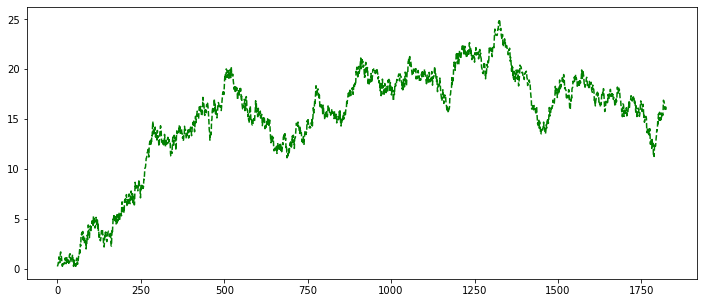

In [149]:
N = 5*365
shape, scale = 100, 3 
y = gen_prices(N)
fig = plt.figure(figsize=(12,5))
plt.plot(y, color='green', linestyle='dashed', label="y_pred")

In [2]:
# Jun 03 2019 (start)
# supply = 554103161

# June 28th, 2021
# supply 614730694

# Aug 23, 2021 
# supply 617746652

# July 12th, 2022 
# supply 650631036 + 100000000 - 13116676 = 737514361

In [3]:
utxo_supply = 650631037.54678924
nevm_supply = 100000000 - 13116676.320312181517900351
tot_supply = utxo_supply + nevm_supply # July 12th, 2022
tot_supply

737514361.2264771

### Ethereum Transaction Fees
* https://etherscan.io/chart/transactionfee
* last download: July 12th, 2022 

In [4]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [5]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [6]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [7]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [8]:
N = 365
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
STRT_YR = 2019
DEFLATION = 0.05
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45
NUM_DAILY_BLOCKS = 24*60

def gen_block_rewards(strt_date = STRT_DATE,
                      strt_supply = STRT_SUPPLY,
                      ini_blk_reward = INITIAL_BLK_REWARD,
                      n = N,
                      deflation = DEFLATION,
                      num_daily_blocks = NUM_DAILY_BLOCKS,
                      nevm_rewards = None,
                      pow_rewards = None):
    
    STRT_YR = datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S").year
    blk_rewards = [ini_blk_reward]
    dates = np.array([getDate(t, strt_date = strt_date) for t in range(0,n)])
    da = np.array([dates.flatten()[t].day for t in range(0,n)])
    mo = np.array([dates.flatten()[t].month for t in range(0,n)])
    yr = np.array([dates.flatten()[t].year for t in range(0,n)])

    rewards = np.repeat(0.0,n)
    rewards[0] = blk_rewards[0]

    for k in range(1, n):
        diff_yr = yr[k] - yr[k-1]
        diff_mo = mo[k] - mo[k-1]
        rewards[k] = blk_rewards[len(blk_rewards)-1]
        
        if diff_mo == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
        
        if diff_yr == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
            blk_rewards.append(blk_reward - deflation*blk_reward)

    daily_rewards = rewards*num_daily_blocks       
            
    df = pd.DataFrame({'dates':dates.flatten(),
                       'yr':yr.flatten(),
                       'mo':mo.flatten(),
                       'da':da.flatten(),
                       'blk_reward':rewards,
                       'daily_rewards':daily_rewards,
                       'supply':strt_supply+np.cumsum(daily_rewards)})
    
    if (nevm_rewards != None): 
        df.insert(loc=5, column='nevm_rewards', value=nevm_rewards)

    if (pow_rewards != None): 
        df.insert(loc=6, column='pow_rewards', value=pow_rewards)  
        
    if (nevm_rewards != None) & (pow_rewards != None):
        rewards = rewards + np.repeat(nevm_rewards,n)
        daily_rewards = rewards*num_daily_blocks 
        df = df.assign(daily_rewards=daily_rewards)
          
    return df

### Supply Pre-NEVM

In [9]:
INDEX = 812
SUPPLY_AT_INDEX = 617746652 # Aug 23, 2021 
N_DAYS_TO_NEVM = 917

def objective_function(alpha):
    
    pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = alpha*38.5,
                           n = N_DAYS_TO_NEVM)
                  
    return abs(SUPPLY_AT_INDEX - pow_df['supply'].iloc[INDEX])

In [10]:
ALPHA_INIT = 1.4872300387520823
result = minimize(objective_function, ALPHA_INIT, method='SLSQP', options={'maxiter': 1000})
alpha_hat = result.x[0]
alpha_hat

1.487230114402233

In [11]:
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = alpha_hat*38.5

pre_nevm = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N_DAYS_TO_NEVM)

In [12]:
pre_nevm.tail(3)

,dates,yr,mo,da,blk_reward,daily_rewards,supply
914,2021-12-03,2021,12,3,51.675669,74412.963882,6.253368e+08
915,2021-12-04,2021,12,4,51.675669,74412.963882,6.254112e+08
916,2021-12-05,2021,12,5,51.675669,74412.963882,6.254856e+08


### Supply Post-NEVM

In [13]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 23.45)

nevm_lwr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 5.27)

In [40]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*pre_nevm['blk_reward'].iloc[-1]

nevm_med = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           #nevm_rewards = 10.55,
                           #pow_rewards = 10.55)
                           nevm_rewards = 0,
                           pow_rewards = 0)

In [32]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 46.9)

nevm_upr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [33]:
nevm_df = nevm_lwr.iloc[:, [0,1,2,3]]
nevm_df.insert(loc=4, column='blk_reward_lwr', value=nevm_lwr['blk_reward'].values)
nevm_df.insert(loc=5, column='nevm_rewards_lwr', value=nevm_lwr['nevm_rewards'].values)
nevm_df.insert(loc=6, column='pow_rewards_lwr', value=nevm_lwr['pow_rewards'].values)
nevm_df.insert(loc=7, column='daily_rewards_lwr', value=nevm_lwr['daily_rewards'].values)
nevm_df.insert(loc=8, column='supply_lwr', value=nevm_lwr['supply'].values)

nevm_df.insert(loc=9, column='blk_reward_upr', value=nevm_upr['blk_reward'].values)
nevm_df.insert(loc=10, column='nevm_rewards_upr', value=nevm_upr['nevm_rewards'].values)
nevm_df.insert(loc=11, column='pow_rewards_upr', value=nevm_upr['pow_rewards'].values)
nevm_df.insert(loc=12, column='daily_rewards_upr', value=nevm_upr['daily_rewards'].values)
nevm_df.insert(loc=13, column='supply_upr', value=nevm_upr['supply'].values)

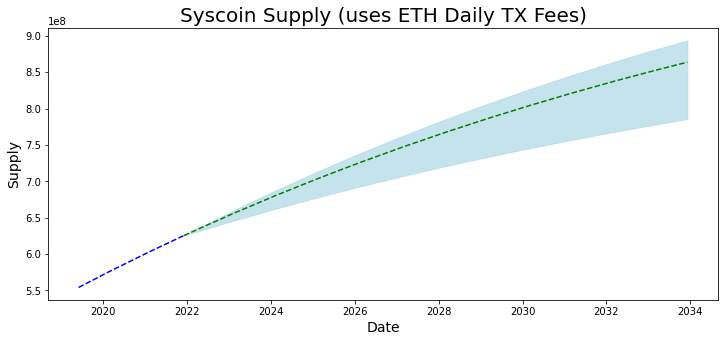

In [34]:
fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_df['dates'].values, nevm_df['supply_lwr'].values, nevm_df['supply_upr'].values, alpha=0.7, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
plt.ylabel("Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)
fig.savefig('../img/syscoin_daily_supply.png')

In [18]:
import statsmodels.api as sm

N = 12*365

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2439,2439+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [19]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [20]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [21]:
dates = [getDate(t) for t in range(0,2439)]
dates_pred = [getDate(t) for t in range(2440,2440+N)]

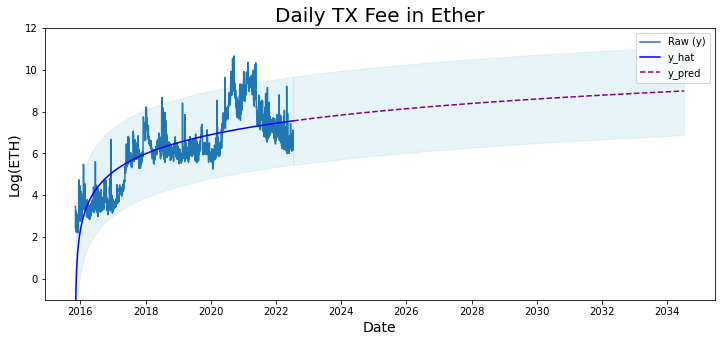

In [22]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2440,2440+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

plt.plot(dates_pred, y_pred, color='purple', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log(ETH)", fontsize=14)
plt.ylim(-1,12)
plt.legend();
fig.savefig('../img/eth_daily_tx_fee.png')

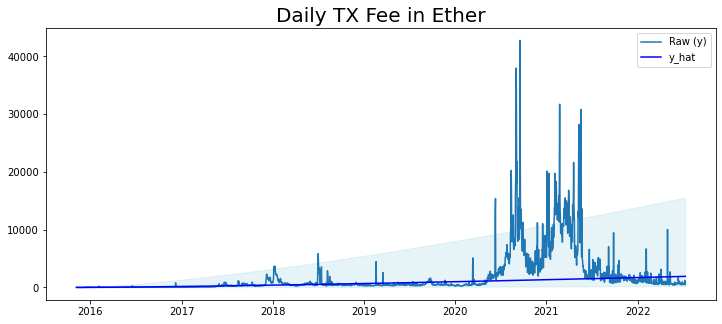

In [30]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

In [24]:
dates_ = np.append(dates, dates_pred[1:])
y_hat_ = np.append(y_hat, y_pred[1:])
y_hat_lwr_ = np.append(y_hat_lwr, y_pred_lwr[1:])
y_pred_upr_ = np.append(y_hat_upr, y_pred_upr[1:])

est_df = pd.DataFrame({'dates':dates_,
                        'pred':np.cumsum(np.exp(y_hat_)),
                        'pred_lwr':np.cumsum(np.exp(y_hat_lwr_)),
                        'pred_upr':np.cumsum(np.exp(y_pred_upr_))})

est_df = est_df.iloc[0:len(nevm_df)]

Text(0.5, 24.0, 'Date')

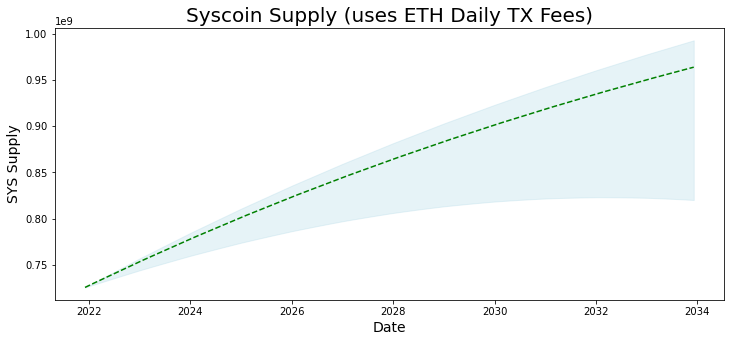

In [25]:
addition_supply = 100000000

coin_supply_upr = addition_supply + nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = addition_supply + nevm_df['supply_lwr'].values - est_df['pred_upr'].values


sys_dates = nevm_med['dates'].values
sys_supply =  addition_supply+nevm_med['supply'].values

fig = plt.figure(figsize=(12,5))
plt.plot(sys_dates, sys_supply, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

Text(0.5, 24.0, 'Date')

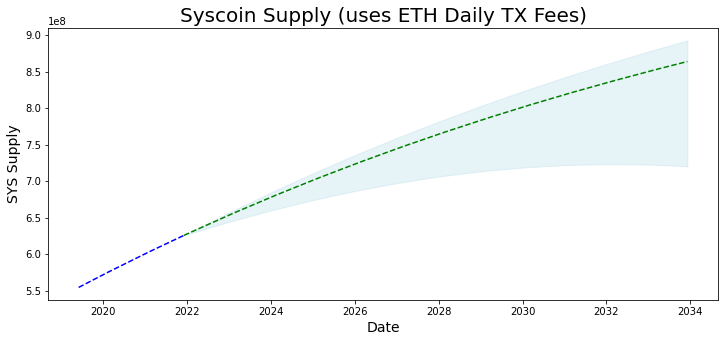

In [26]:
coin_supply_upr = nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = nevm_df['supply_lwr'].values - est_df['pred_upr'].values

fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

In [27]:
pred_df = pd.DataFrame({'dates': nevm_med['dates'].values,
                        'pred':addition_supply + nevm_med['supply'].values,
                        'pred_lwr':addition_supply + coin_supply_lwr,
                        'pred_upr':addition_supply + coin_supply_upr})

In [28]:
mo = pd.to_datetime(pred_df['dates'].values).month
da = pd.to_datetime(pred_df['dates'].values).day

indices = []
m = 0
for k in range(0,len(pred_df)):
    if((mo[k] == 1) & (da[k] == 1)): indices.append(k)
    
pred_df.iloc[indices]

,dates,pred,pred_lwr,pred_upr
26,2022-01-01,7.274948e+08,7.268354e+08,7.277474e+08
391,2023-01-01,7.532974e+08,7.439737e+08,7.567923e+08
756,2024-01-01,7.778100e+08,7.596786e+08,7.843763e+08
1122,2025-01-01,8.011607e+08,7.738528e+08,8.106408e+08
1487,2026-01-01,8.232833e+08,7.863329e+08,8.355096e+08
1852,2027-01-01,8.442998e+08,7.970949e+08,8.591184e+08
2217,2028-01-01,8.642654e+08,8.060879e+08,8.815281e+08
2583,2029-01-01,8.832847e+08,8.132426e+08,9.028556e+08
2948,2030-01-01,9.013037e+08,8.184441e+08,9.230400e+08
3313,2031-01-01,9.184218e+08,8.217405e+08,9.421912e+08
